In [1]:
import sys
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from cmcrameri import cm
sys.dont_write_bytecode = True
import numpy as np
from testing_suite import *
from parameters import *
from algorithm import *
import functions as fcn
import time
import matplotlib.pyplot as plt
import math
import itertools
import random as rand
import pandas as pd
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import LogLocator, LogFormatter, NullFormatter, FuncFormatter

c_cool = '#4055c8'
c_warm = '#ba162c'
master_cmap = 'coolwarm'

# Define colors from #4055c8 (blue) to 90% white (slightly tinted)
disc_colors = [
    "#4055c8",  # Category 1 (blue)
    "#7a8ae0",  # Category 2 (lighter blue)
    "#a6b0ed",  # Category 3 (even lighter)
    "#d1d6f7",  # Category 4 (very light)
    "#e6e6fa"   # Category 5 (90% white, slightly lavender)
]

# Create a ListedColormap
master_cmap_seq = mcolors.ListedColormap(disc_colors, name="custom_qualitative")

# plt.style.use('dark_background')
#plt.style.use('tableau-colorblind10')

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

f = 1

In [2]:
# create dataframe containing all data to be evaluated

if False:
    master_df = None
    cnt = 1
    directory = "C:\\Users\\stijn Hennissen\\Jupyter Notebooks\\Nast Thesis\\Testing suite\\suit_result_files\\"

    for filename in os.listdir(directory)[:]:
        if filename.endswith(".json"):
            file_df = pd.read_json(directory+filename)
            if cnt == 1:
                master_df = file_df.tail(1).copy()
                master_df.index = [0]
            else:
                master_df = master_df.append(file_df.tail(1).copy(), ignore_index=True)
            master_df.reset_index()
            i = master_df.index[-1]
            m_timer_main = np.mean(np.array([l[1:-1].split() for l in str(file_df['timer_main'])]).astype(float), axis=0)
            for j in range(0, m_timer_main.size):
                master_df.loc[i, 'timer_main_'+str(j+1)] = m_timer_main[j]
            master_df.loc[i, ['timer_iter', 'timerest_iter', 'delta_time']] = np.mean(np.array(file_df[['timer_iter', 'timerest_iter', 'delta_time']].values), axis=0)
            
            cnt += 1
    master_df.drop('timer_main', axis=1, inplace=True)
    master_df.to_json('master_df_3.json')


In [3]:
data = pd.read_json("C:\\Users\\stijn Hennissen\\Jupyter Notebooks\\Nast Thesis\\Testing suite\\master_df_3.json")
data.drop(data[data['min_score'] <= 0].index, inplace=True)
data.reset_index()
data.rename(columns={'timer_main_1': 'timer_selection', 'timer_main_2': 'timer_mutation', 'timer_main_3': 'timer_shuffle', 'timer_main_4': 'timer_crossover', 'timer_main_5': 'timer_fitness'}, inplace=True)

In [4]:
# Plot score against time

if False:

    plt.figure(f)
    g1 = sns.scatterplot(
        data = data,
        x = 'min_score',
        y = 'elapsed_time',
        hue = 'MP_population_size',
        palette = disc_colors[:3]
    )
    plt.xscale('log')
    plt.xlim(1e-12,1e31)
    plt.legend(title='population size', loc='upper right')
    plt.xlabel('Best/lowest score (capped at $10^{30}$)')
    plt.ylabel('Total runtime (s)')
    plt.title('Score against runtime for testing suite results')
    plt.savefig('all_results_scaterplot.png', dpi=300)
    plt.show()
    f += 1


    plt.figure(f, figsize=(12+31, 7))
    g1 = sns.scatterplot(
        data=data,
        x='min_score',
        y='elapsed_time',
        hue='MP_population_size',
        palette = disc_colors[:3]
    )

    # --- Log-scale x-axis settings ---
    plt.xscale('log')
    plt.xlim(1e-12, 1e31)

    # ===== Custom formatter for powers of 10 =====
    def power_of_10_formatter(x, pos):
        exponent = int(np.log10(x))
        return r'$10^{{{}}}$'.format(exponent)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(power_of_10_formatter))

    # ===== Tick locations =====
    # Major ticks (every order of magnitude)
    major_exponents = np.arange(-12, 32)  # From 1e-12 to 1e31
    major_tick_positions = 10.0 ** major_exponents
    ax.set_xticks(major_tick_positions)

    # Minor ticks (2x10^n through 9x10^n)
    multipliers = np.arange(2, 10)
    minor_tick_positions = np.outer(multipliers, 10.0 ** np.arange(-12, 31)).flatten()
    ax.set_xticks(minor_tick_positions, minor=True)
    ax.xaxis.set_minor_formatter(NullFormatter())

    # ===== Gridlines =====
    ax.grid(True, which='major', linestyle='-', linewidth=1, alpha=0.8)
    ax.grid(True, which='minor', linestyle='-', linewidth=0.7, alpha=0.5)  # Minor gridlines enabled!

    # --- Plot aesthetics ---
    plt.legend(title='Population size', loc='upper right')
    plt.xlabel('Best/lowest score (capped at $10^{30}$)')
    plt.ylabel('Total runtime (s)')
    plt.title('Score against runtime for testing suite results')

    plt.savefig('all_results_scatterplot.png', dpi=300, bbox_inches='tight')
    plt.show()



    plt.figure(f, figsize=(6,6))
    g3 = sns.histplot(
        data = data.loc[data['min_score'] > 0],
        x = 'min_score',
        y = 'elapsed_time',
        hue = 'MP_population_size',
        log_scale=[True, False],
        bins = [np.linspace(-12, 31, num=86), np.arange(0, 3.5, 0.25)],
    )
    plt.xlim(1e-12,1e31)
    plt.ylim(0, 3.5)
    g3.legend_.set_title('Population size')
    divider = make_axes_locatable(g3)
    divider_kwargs = dict(position="right", size="5%", pad=0.1)
    cbar_3_1 = plt.colorbar(g3.collections[0], ax=g3, cax=divider.append_axes(**divider_kwargs))
    cbar_3_2 = plt.colorbar(g3.collections[1], ax=g3, cax=divider.append_axes(**divider_kwargs))
    cbar_3_3 = plt.colorbar(g3.collections[2], ax=g3, cax=divider.append_axes(**divider_kwargs))
    cbar_3_2.set_ticks([])
    cbar_3_1.set_ticks([])
    g3.set(xlabel = 'Best/lowest score (capped at $10^{30}$)', ylabel = 'Total runtime (s)')
    g3.set(title = 'Score against runtime for testing suite results')
    plt.show()
    f += 1

In [5]:
# Plot hists of scores

def plot_hist_scores(column, f, palette):
    
    title = column[3:].split('_')
    
    plt.figure(f)
    fig, axs = plt.subplots(nrows=3, figsize=(3,5*3))

    g20 = sns.histplot(
        data = data.loc[data['min_score'] > 0],
        x = 'min_score',
        hue = column,
        log_scale = True,
        multiple = "stack",
        bins = np.linspace(-12, 0, num=13),
        ax = axs[0],
        palette = palette
    )
    axs[0].set_xlim([1e-12,1])
    axs[0].get_legend().set_title(f'{title[0]} {title[1]}')

    g21 = sns.histplot(
        data = data.loc[data['min_score'] > 0],
        x = 'min_score',
        hue = column,
        log_scale = True,
        multiple = "stack",
        bins = np.linspace(-12, 20, num=33),
        ax = axs[1],
        palette = palette
    )
    axs[1].set_xlim([1e-12,1e20])
    axs[1].get_legend().set_title(f'{title[0]} {title[1]}')

    g22 = sns.histplot(
        data = data.loc[data['min_score'] > 0],
        x = 'min_score',
        hue = column,
        log_scale = True,
        multiple = "stack",
        bins = np.linspace(-12, 31, num=44),
        ax = axs[2],
        palette = palette
    )
    axs[2].set_xlim([1e-12,1e31])
    axs[2].get_legend().set_title(f'{title[0]} {title[1]}')

    axs[0].set_xlabel('')
    axs[2].set_xlabel('Best/lowest score (capped at $10^{30}$)')
    axs[1].set_xlabel('')
    #axs[0].set_ylabel('Count')
    #axs[1].set_ylabel('Count')
    #axs[2].set_ylabel('Count')
    axs[0].set_ylabel('')
    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    
    axs[0].set_title(f'Score distr. per {title[0]} {title[1]}')
    plt.savefig(f'{column}.png', dpi=300)
    plt.show()
    return f + 1

if False:
    palette = ['#d3bda5', '#d2d6d5', '#2388bc', '#63a2bc', '#2b7291', '#0c6391', '#003e6c']
    f = plot_hist_scores('MP_population_size', f, disc_colors[:3])
    f = plot_hist_scores('CP_keep_percent', f, disc_colors[:5])
    f = plot_hist_scores('CP_crossover_percent', f, disc_colors[:5])
    f = plot_hist_scores('CP_mutation_percent', f, disc_colors[:4])
    f = plot_hist_scores('CP_mutation_amount', f, disc_colors[:4])

In [6]:
# Correlations
if False:
    corr_columns1 = ['timer_iter', 'timer_selection', 'timer_mutation', 'timer_shuffle', 'timer_crossover', 'timer_fitness', 'timerest_iter', 'MP_population_size']
    plt.figure()
    sns.pairplot(data[corr_columns1], hue='MP_population_size', palette = ['red', 'green', 'blue'], kind='reg', markers='.', plot_kws={'scatter_kws': {'alpha': 0.1}})
    plt.show()

    corr_columns1 = ['timer_iter', 'timer_crossover', 'CP_crossover_percent']
    plt.figure()
    sns.pairplot(data[corr_columns1], hue='CP_crossover_percent', palette = palette[:5], kind='reg', markers='.', plot_kws={'scatter_kws': {'alpha': 0.5}})
    plt.show()

    corr_columns1 = ['timer_iter', 'timer_mutation', 'CP_mutation_percent']
    plt.figure()
    sns.pairplot(data[corr_columns1], hue='CP_mutation_percent', palette = palette[:4], kind='reg', markers='.', plot_kws={'scatter_kws': {'alpha': 0.5}})
    plt.show()

    corr_columns1 = ['timer_iter', 'timer_mutation', 'CP_mutation_amount']
    plt.figure()
    sns.pairplot(data[corr_columns1], hue='CP_mutation_amount', palette = palette[:4], kind='reg', markers='.', plot_kws={'scatter_kws': {'alpha': 0.5}})
    plt.show()

In [7]:
# Find Paretro optima

def find_pareto_optima_2d(data, c1, c2):
    pareto_df = pd.DataFrame(columns=data.columns)
    for i, row in data.iterrows():
        is_dominated = False
        is_duplicate = False
        for j, other_row in data.iterrows():
            if i == j:
                continue
            # Check if the other solution dominates the current solution
            if (other_row[c1] < row[c1] and other_row[c2] < row[c2]):
                # The other solution dominates the current solution and hence row cannot be added to pareto set.
                is_dominated = True
                break
            # Check if the other solution is a duplicate
            if (other_row[c1] == row[c1] and other_row[c2] == row[c2]):
                is_duplicate = True
                break

        if not is_dominated:
            # The current solution is Pareto-optimal
            row_df = pd.DataFrame([row])
            pareto_df = pd.concat([pareto_df, row_df], ignore_index=True)

    return pareto_df

pareto_front = find_pareto_optima_2d(data, 'min_score', 'elapsed_time')
pareto_front = pareto_front.sort_values(by='min_score')

print(pareto_front[['min_score', 'elapsed_time']])

        min_score  elapsed_time
0    1.000000e+30     40.398575
92   1.000000e+30    430.872159
91   1.000000e+30    427.933820
90   1.000000e+30    417.833621
89   1.000000e+30    431.563250
..            ...           ...
35   1.000000e+30     41.753101
34   1.000000e+30     42.307853
33   1.000000e+30     40.103643
46   1.000000e+30     83.292597
126  1.000000e+30    107.459660

[127 rows x 2 columns]


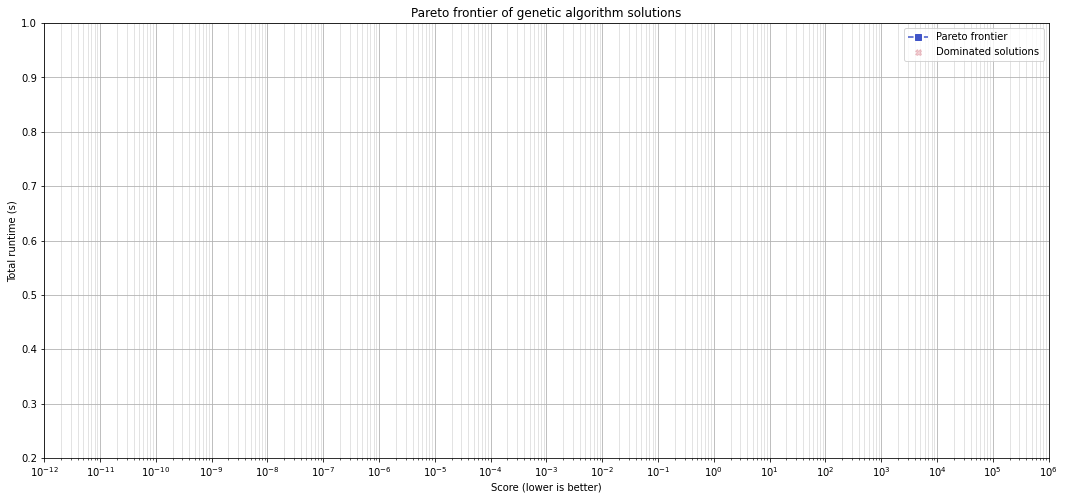

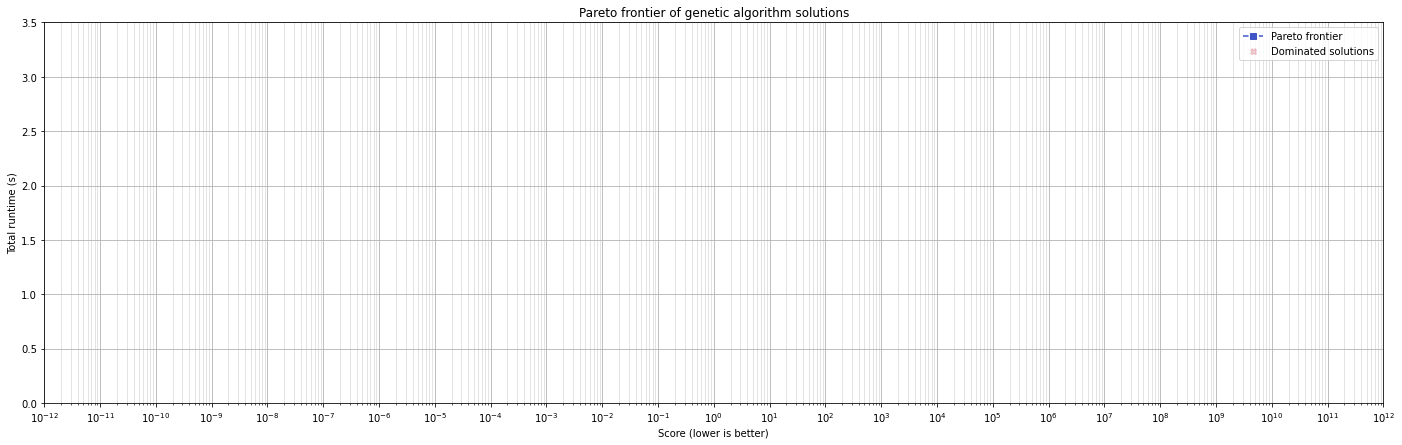

In [8]:
# plot pareto front
# c='#4aa127',
# c='#b53a95',

plt.figure(figsize=(18, 8))
ax = plt.gca()

# --- Plot data ---
plt.plot(
    pareto_front['min_score'].values,
    pareto_front['elapsed_time'].values,
    's--',
    label='Pareto frontier',
    c=c_cool,
    zorder=10
)
plt.plot(
    data['min_score'].values,
    data['elapsed_time'].values,
    'X',
    label='Dominated solutions',
    alpha=0.2,
    c=c_warm,
    zorder=5
)

# --- Log-scale x-axis settings ---
plt.xscale('log')
plt.xlim(1e-12, 1e6)

# ===== 1. Custom formatter for powers of 10 =====
def power_of_10_formatter(x, pos):
    exponent = int(np.log10(x))
    return r'$10^{{{}}}$'.format(exponent)

ax.xaxis.set_major_formatter(FuncFormatter(power_of_10_formatter))

# ===== 2. Major ticks (every order of magnitude) =====
major_exponents = np.arange(-12, 7)  # From 1e-12 to 1e6
major_tick_positions = 10.0 ** major_exponents
ax.set_xticks(major_tick_positions)

# ===== 3. Minor ticks (2x10^n, 3x10^n, ..., 9x10^n) =====
multipliers = np.arange(2, 10)
minor_tick_positions = np.outer(multipliers, 10.0 ** np.arange(-12, 6)).flatten()
ax.set_xticks(minor_tick_positions, minor=True)
ax.xaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

# ===== 4. Gridlines (MAJOR and MINOR) =====
ax.grid(True, which='major', linestyle='-', linewidth=1, alpha=0.8)
ax.grid(True, which='minor', linestyle='-', linewidth=0.7, alpha=0.5)  # Minor gridlines enabled!

# --- Plot aesthetics ---
plt.ylim(0.2, 1)
plt.legend()
plt.xlabel('Score (lower is better)')
plt.ylabel('Total runtime (s)')
plt.title('Pareto frontier of genetic algorithm solutions')

plt.savefig('pareto.png', dpi=300, bbox_inches='tight')
plt.show()
f += 1





plt.figure(figsize=(24, 7))
ax = plt.gca()

# --- Plot data ---
plt.plot(
    pareto_front['min_score'].values,
    pareto_front['elapsed_time'].values,
    's--',
    label='Pareto frontier',
    c=c_cool,
    zorder=10
)
plt.plot(
    data['min_score'].values,
    data['elapsed_time'].values,
    'X',
    label='Dominated solutions',
    alpha=0.2,
    c=c_warm,
    zorder=5
)

# --- Log-scale x-axis settings ---
plt.xscale('log')
plt.xlim(1e-12, 1e12)

# ===== 1. Custom formatter for powers of 10 =====
def power_of_10_formatter(x, pos):
    exponent = int(np.log10(x))
    return r'$10^{{{}}}$'.format(exponent)

ax.xaxis.set_major_formatter(FuncFormatter(power_of_10_formatter))

# ===== 2. Major ticks (every order of magnitude) =====
major_exponents = np.arange(-12, 13)  # From 1e-12 to 1e6
major_tick_positions = 10.0 ** major_exponents
ax.set_xticks(major_tick_positions)

# ===== 3. Minor ticks (2x10^n, 3x10^n, ..., 9x10^n) =====
multipliers = np.arange(2, 10)
minor_tick_positions = np.outer(multipliers, 10.0 ** np.arange(-12, 12)).flatten()
ax.set_xticks(minor_tick_positions, minor=True)
ax.xaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

# ===== 4. Gridlines (MAJOR and MINOR) =====
ax.grid(True, which='major', linestyle='-', linewidth=1, alpha=0.8)
ax.grid(True, which='minor', linestyle='-', linewidth=0.7, alpha=0.5)  # Minor gridlines enabled!

# --- Plot aesthetics ---
plt.ylim(0, 3.5)
plt.legend()
plt.xlabel('Score (lower is better)')
plt.ylabel('Total runtime (s)')
plt.title('Pareto frontier of genetic algorithm solutions')

plt.savefig('pareto_full.png', dpi=300, bbox_inches='tight')
plt.show()
f += 1

In [9]:
# Analyze generating function (this part is specific to this set of tests)

def generate_grid(fixed_point, collocation_point_numbers, collocation_point_bounds):
    n_p = collocation_point_numbers # u-, u+, v-, v+
    B_p = collocation_point_bounds # u-, u+, v-, v+
    fp = fixed_point # u, v

    um = np.linspace(fp[0]-B_p[0], fp[0], n_p[0]+1) # u- to u*
    up = np.linspace(fp[0], fp[0]+B_p[1], n_p[1]+1) # u* to u+
    vm = np.linspace(fp[1]-B_p[2], fp[1], n_p[2]+1) # v- to v*
    vp = np.linspace(fp[1], fp[1]+B_p[3], n_p[3]+1) # v* to v+

    u_mp, v_mp = np.meshgrid(um, vp, indexing='ij') # exclude none
    u_pp, v_pp = np.meshgrid(up[1:], vp, indexing='ij') # exclude u*
    u_mm, v_mm = np.meshgrid(um, vm[:-1], indexing='ij') # exclude v*
    u_pm, v_pm = np.meshgrid(up[1:], vm[:-1], indexing='ij') # exclude u* and v*

    u_vp = np.concatenate((u_mp, u_pp))
    v_vp = np.concatenate((v_mp, v_pp))
    u_vm = np.concatenate((u_mm, u_pm))
    v_vm = np.concatenate((v_mm, v_pm))

    u = np.concatenate((u_vm, u_vp), axis=1)
    v = np.concatenate((v_vm, v_vp), axis=1)
        
    grid = np.array([u,v], dtype=np.float32)

    points = np.transpose(np.vstack([u.ravel(order='F'), v.ravel(order='F')]))

    return points, grid, np.array([], dtype=np.float32)
    
    
def calculate_smoothness(collocation_point_numbers, collocation_point_bounds):
    return np.min(np.divide(collocation_point_bounds, collocation_point_numbers))
    
    
def precalculate_tensors(collocation_points, F_fp, psi, dpsi, beta, N_p, sigma, N):
    dpsi(collocation_points, N_p, sigma, N, np.transpose(collocation_points), collocation_points)
    return np.array([F_fp(cp) for cp in collocation_points], dtype=np.float32), psi(collocation_points, N_p, sigma, N, np.transpose(collocation_points)), dpsi(collocation_points, N_p, sigma, N, np.transpose(collocation_points), collocation_points), beta(collocation_points)
    

beta_functions = fcn.beta
fixed_point = np.array([343/(288*math.pi), -49/(288*math.pi)])
true_result = 0.15
linear_generating_function = fcn.F_fp
collocation_point_numbers = np.array([20,5,10,30])
collocation_point_bounds = np.array([.5,.3,.3,.5])
basis_functions = fcn.psi
basis_functions_derivatives = fcn.dpsi
N = 2

collocation_points, grid, core_ids = generate_grid(fixed_point, collocation_point_numbers, collocation_point_bounds)
            
N_p = collocation_points.shape[0]
            
smoothness = calculate_smoothness(collocation_point_numbers, collocation_point_bounds)
            
F_fp, pc_psi, dpsi, beta = precalculate_tensors(
                collocation_points, 
                linear_generating_function, 
                basis_functions, 
                basis_functions_derivatives, 
                beta_functions,
                N_p, 
                smoothness,
                N
)

# find fixed point id
fp_id = 0
for i in range(0, collocation_points.shape[0]):
    if collocation_points[i,0] == fixed_point[0] and collocation_points[i,1] == fixed_point[1]:
        fp_id = i
        break
        

In [10]:

if False:
    # Create figure with extra-wide aspect (12+31=43 width)
    plt.figure(figsize=(12, 3.5))
    ax = plt.gca()

    # --- Plot all solutions colored by population size ---
    scatter = sns.scatterplot(
        data=data,
        x='min_score',
        y='elapsed_time',
        hue='MP_population_size',
        palette=disc_colors[:3],
        alpha=1,
        legend='auto',
        zorder=5
    )

    # --- Plot Pareto frontier ---
    plt.plot(
        pareto_front['min_score'].values,
        pareto_front['elapsed_time'].values,
        's--',
        markersize=5,
        markeredgewidth=1.5,
        label='Pareto frontier',
        c='#ff0000',  # Bright red for visibility
        zorder=10
    )

    # --- Log-scale x-axis settings ---
    plt.xscale('log')
    plt.xlim(1e-12, 1e12)

    # ===== Custom formatter for powers of 10 =====
    def power_of_10_formatter(x, pos):
        if x <= 0:
            return '0'
        exponent = int(np.log10(x))
        return r'$10^{{{}}}$'.format(exponent)

    ax.xaxis.set_major_formatter(FuncFormatter(power_of_10_formatter))

    # ===== Tick locations =====
    # Major ticks (every order of magnitude)
    major_exponents = np.arange(-12, 31)  # From 1e-12 to 1e31
    major_tick_positions = 10.0 ** major_exponents
    ax.set_xticks(major_tick_positions)

    # Minor ticks (2x10^n through 9x10^n)
    multipliers = np.arange(2, 10)
    minor_tick_positions = np.outer(multipliers, 10.0 ** np.arange(-12, 31)).flatten()
    ax.set_xticks(minor_tick_positions, minor=True)
    ax.xaxis.set_minor_formatter(NullFormatter())

    # ===== Enhanced Gridlines =====
    ax.grid(True, which='major', linestyle='-', linewidth=1, alpha=0.8)
    ax.grid(True, which='minor', linestyle='-', linewidth=0.7, alpha=0.5)

    # --- Plot aesthetics ---
    plt.legend(title='Population Size', loc='upper right')
    plt.xlabel('Best/lowest score (log scale)', fontsize=12)
    plt.ylabel('Total runtime (s)', fontsize=12)
    plt.title('Pareto Frontier and Population Size', fontsize=14, pad=20)

    # Adjust legend for two different elements
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[-4:], labels[-4:], title='Population Size', loc='upper right')

    plt.xlim(1e-12, 1e12)

    plt.savefig('pareto_population_comparison.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white')
    plt.show()

        min_score    mean_score  std_score     max_score  timer_iter  \
0    1.000000e+30  9.999999e+29        NaN  1.000000e+30    0.080789   
1    1.000000e+30  9.999999e+29        NaN  1.000000e+30    0.079883   
2    1.000000e+30  9.999999e+29        NaN  1.000000e+30    0.080035   
3    1.000000e+30  9.999999e+29        NaN  1.000000e+30    0.079773   
4    1.000000e+30  9.999999e+29        NaN  1.000000e+30    0.080286   
..            ...           ...        ...           ...         ...   
122  1.000000e+30  1.000000e+30        0.0  1.000000e+30    0.232066   
123  1.000000e+30  1.000000e+30        0.0  1.000000e+30    0.209323   
124  1.000000e+30  1.000000e+30        0.0  1.000000e+30    0.216591   
125  1.000000e+30  1.000000e+30        0.0  1.000000e+30    0.214841   
126  1.000000e+30  1.000000e+30        0.0  1.000000e+30    0.214911   

     timerest_iter  elapsed_time  delta_time  \
0         0.000010     40.398575    0.080797   
1         0.000010     39.945339    0.0

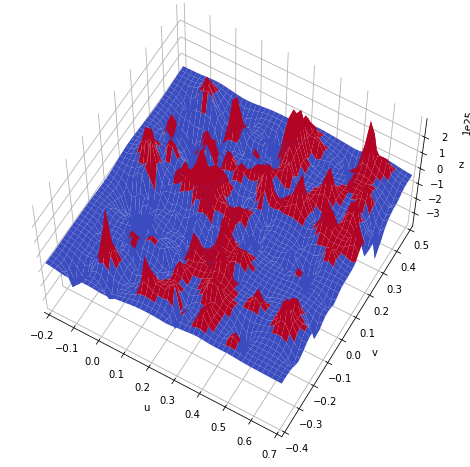

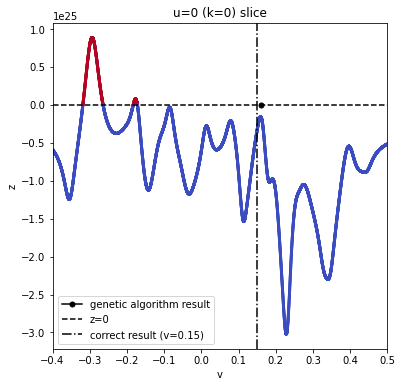

F(0,v)=0 at v=0.15928152815281527

=== id=92, min_score=1.000000015e+30, elapsed_time=430.8721589 ===
(1066, 1)
-2.14962410210347e+25
4.352019989268005e+25


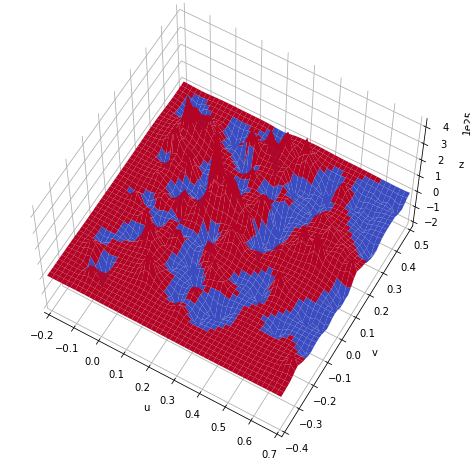

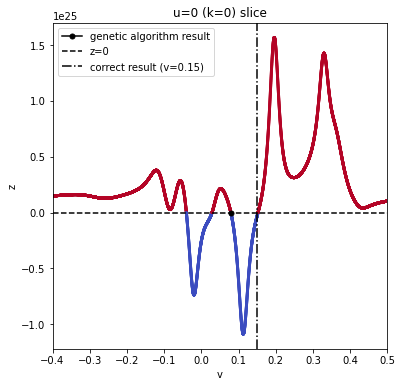

F(0,v)=0 at v=0.07925512551255126



In [11]:
scatter_norm = TwoSlopeNorm(vmin=-1.5974604910058174, vcenter=0, vmax=1.8467932029228253)
master_cmap = 'coolwarm'

print(data)


def get_p_from_df(i):
    p_temp = pareto_front.loc[i, 'best_p']
    p_temp = np.array([p[-1] for p in p_temp], dtype=float)
    p_temp = np.reshape(p_temp, (p_temp.size,1))
    print(p_temp.shape)
    return p_temp

def plot_F(p, res, v_loc):
    x = np.linspace(-0.2, 0.7, res)
    y = np.linspace(-0.4, 0.5, res)
    X, Y = np.meshgrid(x, y)
    G = np.transpose(np.vstack([X.ravel(order='C'), Y.ravel(order='C')]))
    Z = np.reshape(fcn.F_general(G, p, pc_psi, fp_id, N_p, smoothness, N, np.transpose(collocation_points))[:,0], (res, res))
    print(np.min(Z))
    print(np.max(Z))

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=master_cmap, norm=scatter_norm, alpha=1)
    ax.view_init(60, -60)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlabel('u')
    ax.set_ylabel('v')
    ax.set_zlabel('z')
    plt.xlim([-.2, .7])
    plt.ylim([-.4, .5])
    plt.savefig('height.png', dpi=600)
    plt.show()
    
def plot_F_slice(bound, number, p, pc_psi, fp_id, fp, N_cp, sigma, N, CP_transpose, true_result):
    check_coords = np.zeros((number,2))
    check_coords[:,1] = np.linspace(bound[0], bound[1], number)
    x = check_coords[:,1]
    y = fcn.F_general(check_coords,p,pc_psi,fp_id, N_cp, sigma, N, CP_transpose)
    scatter_norm = TwoSlopeNorm(vmin=-1.5974604910058174, vcenter=0, vmax=1.8467932029228253)
    
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, cmap=master_cmap, c=y, marker='.', linewidths=0.0, norm=scatter_norm)
    plt.plot(v_loc,0, marker='.', c='k', label='genetic algorithm result',markersize=10)
    plt.axhline(0, ls='--', c='k', label='z=0')
    plt.axvline(true_result, ls='-.', c='k', label=f'correct result (v=0.15)')
    plt.xlabel('v')
    plt.ylabel('z')
    plt.title('u=0 (k=0) slice')
    plt.xlim((-0.4,0.5))
    plt.legend()
    plt.savefig('slice.png', dpi=300)
    plt.show()
    return x, y

x_list = []
y_list = []
v_list = []

for i in pareto_front.index.to_list()[:2]:
    print(f"=== id={i}, min_score={pareto_front.loc[i, 'min_score']}, elapsed_time={pareto_front.loc[i, 'elapsed_time']} ===")
    p = get_p_from_df(i) 
    v_loc = fcn.findSolutionV2D([0.067,0.5], 10000, p, pc_psi, fp_id, fixed_point, N_p, smoothness, N, np.transpose(collocation_points))
    plot_F(p, 50, v_loc)
    x, y = plot_F_slice([-0.4,0.5], 10000, p, pc_psi, fp_id, fixed_point, N_p, smoothness, N, np.transpose(collocation_points), true_result)
    x_list.append(x)
    y_list.append(y)
    v_list.append(v_loc)
    print(f"F(0,v)=0 at v={v_loc}")
    print()

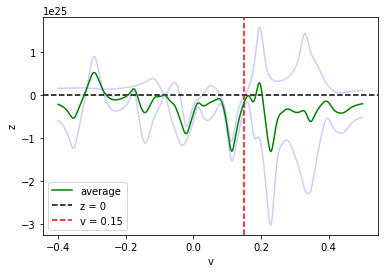

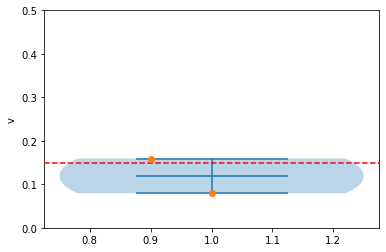

In [12]:
# plot concluding results

plt.figure()
mean_line = np.zeros(len(x_list[0]))
for i in range(0, len(x_list)):
    plt.plot(x_list[i], y_list[i], c='b', alpha=.2, zorder=5)
    mean_line = np.add(mean_line, np.array(y_list[i])[:,0])
    
mean_line = mean_line/len(x_list)
plt.plot(x_list[0], mean_line, c='g', zorder=15, label='average')
plt.axhline(0, ls='--', c='k', label='z = 0', zorder=10)
plt.axvline(true_result, ls='--', c='r', label=f'v = {true_result}', zorder=11)
plt.xlabel('v')
plt.ylabel('z')
plt.legend()
plt.show()

plt.figure()
plt.violinplot(v_list,showmeans=True,showmedians=False)
plt.plot(0.2*np.arange(0, len(v_list))/len(v_list)+0.9, v_list, 'o', zorder=15)
plt.ylabel('v')
plt.ylim([0,0.5])
plt.axhline(true_result, ls='--', c='r', zorder=10)
plt.show()

=== id=0, min_score=1.000000015e+30, elapsed_time=40.3985755 ===
(1066, 1)


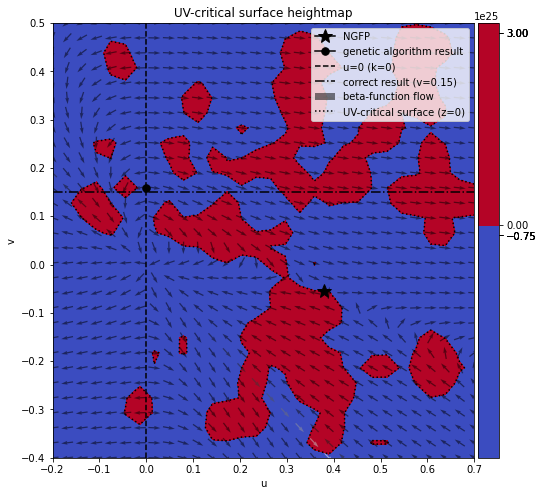

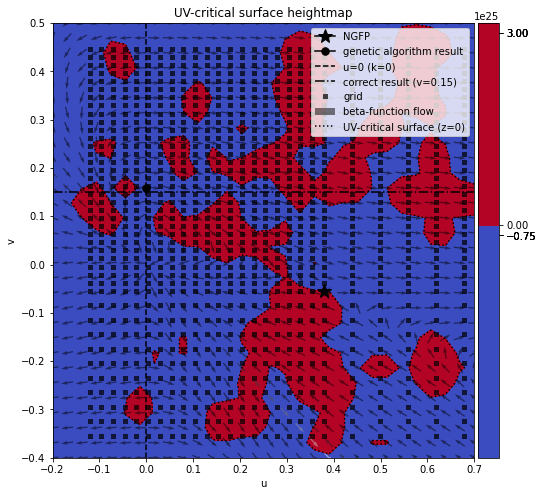

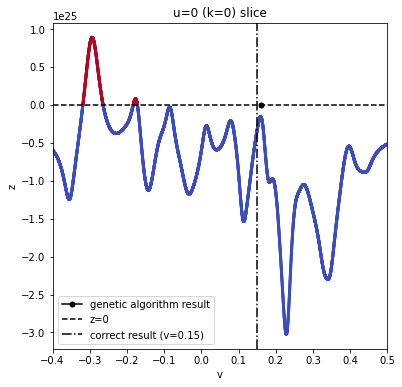

F(0,v)=0 at v=0.15928152815281527

=== id=92, min_score=1.000000015e+30, elapsed_time=430.8721589 ===
(1066, 1)


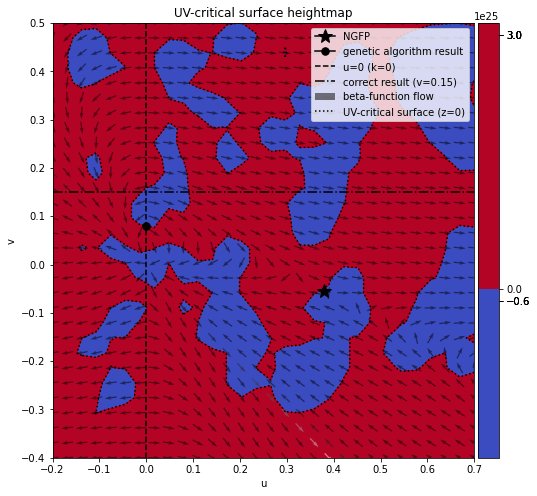

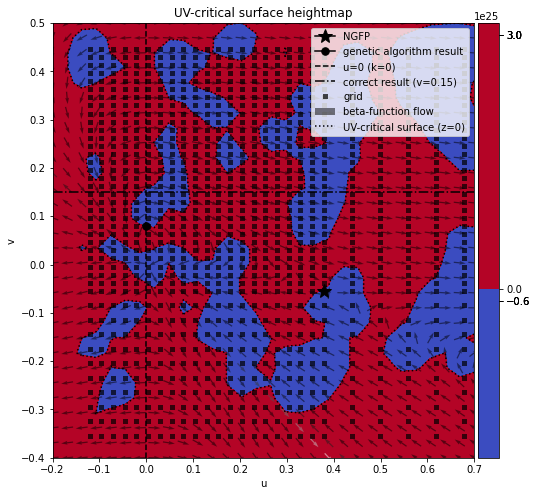

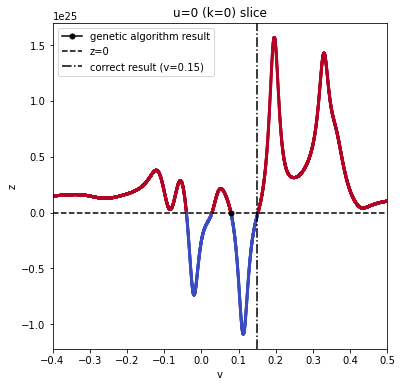

F(0,v)=0 at v=0.07925512551255126

=== id=91, min_score=1.000000015e+30, elapsed_time=427.9338198 ===
(1066, 1)


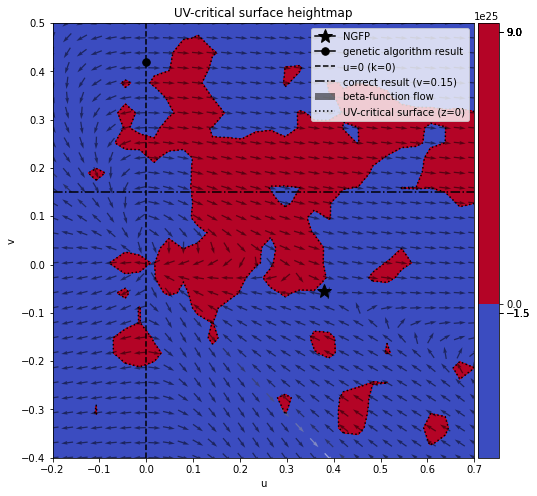

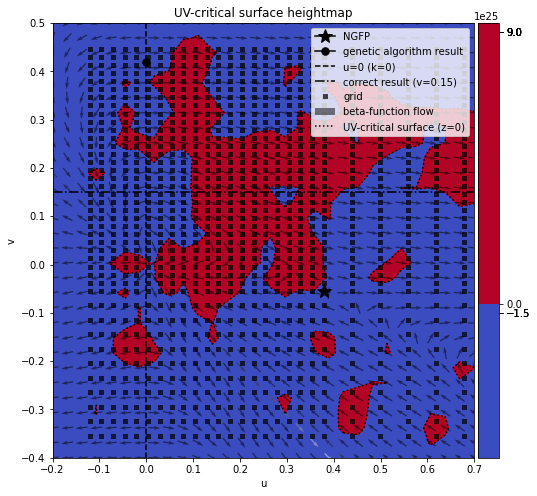

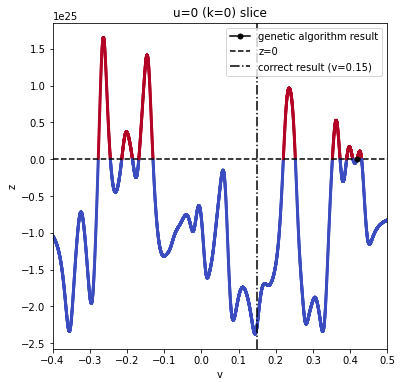

F(0,v)=0 at v=0.41845794579457946

=== id=90, min_score=1.000000015e+30, elapsed_time=417.8336214 ===
(1066, 1)


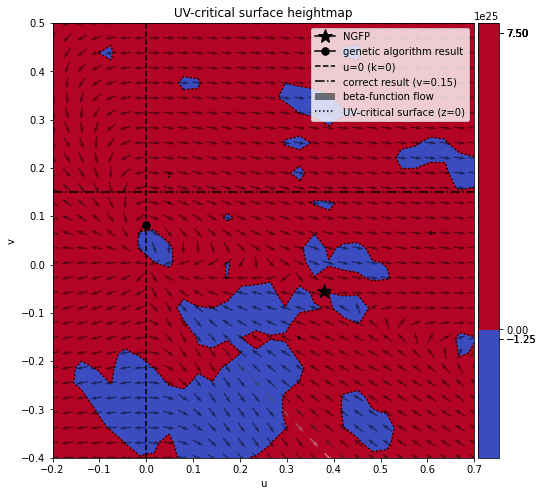

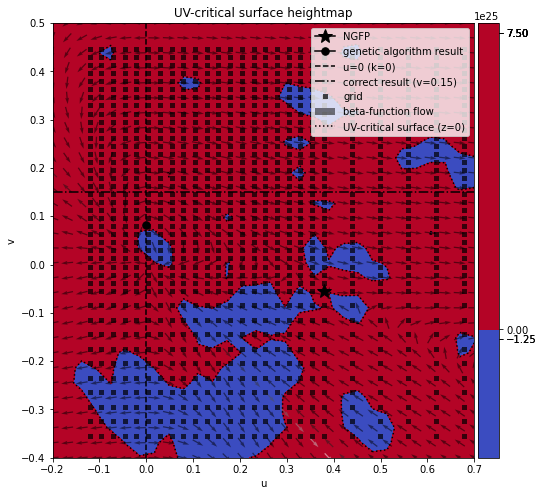

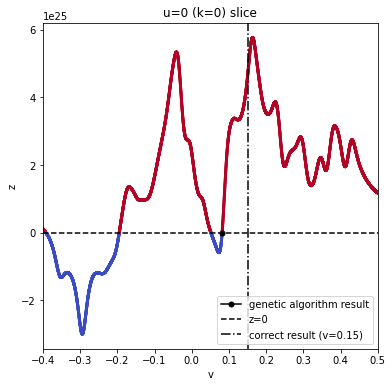

F(0,v)=0 at v=0.08163686368636865



In [13]:
from matplotlib.lines import Line2D

cmap_w = LinearSegmentedColormap.from_list('custom_cmap', [(1, 1, 1, 0), (1, 1, 1, 1)])
cmap_b = LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0, 0), (0, 0, 0, 1)])

marker_size = 15

fixed_point = np.array([343/(288*math.pi), -49/(288*math.pi)])

def plot_F_2(p, res, v_loc):
    
    x = np.linspace(-0.2, 0.7, res)
    y = np.linspace(-0.4, 0.5, res)

    X, Y = np.meshgrid(x, y)
    G = np.transpose(np.vstack([X.ravel(order='C'), Y.ravel(order='C')]))
    Z = np.reshape(fcn.F_general(G, p, pc_psi, fp_id, N_p, smoothness, N, np.transpose(collocation_points))[:,0], (res, res))
    
    beta = fcn.beta(G)
    dz_dx = np.reshape(beta[0], (res, res))
    dz_dy = np.reshape(beta[1], (res, res))
    magnitude = np.sqrt(dz_dx**2 + dz_dy**2)
    
    # Normalize vectors to unit length
    U = dz_dx / magnitude
    V = dz_dy / magnitude
    #dz_dy, dz_dx = np.gradient(Z)
    
    magnitude = np.sqrt(dz_dx**2 + dz_dy**2)
    mag_norm = 1 - (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
    colors = plt.cm.gray_r(mag_norm)
    
    # magnitude = np.log10(magnitude)

    # Normalize magnitude for alpha (range 0.1 to 1 for visibility)
    alpha = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
    alpha = 0.1 + 0.9 * alpha  # scale to [0.1, 1.0]


    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    heightmap = plt.contourf(X, Y, Z, levels=50, cmap=master_cmap, norm=scatter_norm)
    colorbar(heightmap)
    
    
    # Add Z=0 contour
    plt.contour(X, Y, Z, levels=[0], colors='k', linewidths=1.5, linestyles='dotted')
    z0_proxy = Line2D([0], [0], color='k', linestyle='dotted', linewidth=1.5, label='z = 0')
    
    if True:
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if i==0 and j==0:
                    ax.quiver(X[i, j], Y[i, j], U[i, j], V[i, j], angles='xy', scale_units='xy', scale=1.3*res, color=colors[i, j], pivot='middle', width=0.003, alpha=0.5, label='beta-function flow')
                else:
                    ax.quiver(X[i, j], Y[i, j], U[i, j], V[i, j], angles='xy', scale_units='xy', scale=1.3*res, color=colors[i, j], pivot='middle', width=0.003, alpha=0.5)

    plt.plot(fixed_point[0], fixed_point[1], marker='*', markersize=marker_size, color='k', label='NGFP')
    plt.plot(0, v_loc, marker='.', markersize=marker_size, color='k', label = 'genetic algorithm result')
    plt.axvline(0, ls='--', c='k', label='u=0 (k=0)')
    plt.axhline(0.15, ls='-.', c='k', label='correct result (v=0.15)')
    
    
    plt.xlim([-.2, .7])
    plt.ylim([-.4, .5])
    
    plt.xlabel('u')
    plt.ylabel('v')
    plt.title('UV-critical surface heightmap')
        # Get existing legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Add the new proxy to the handles
    handles.append(z0_proxy)
    labels.append('UV-critical surface (z=0)')

    # Draw the legend with updated entries
    ax.legend(handles=handles, labels=labels, loc="upper right")
    plt.savefig('field_lines.png', dpi=300)
    plt.show()
    
    
    
def plot_F_2_grid(p, res, v_loc):
    
    x = np.linspace(-0.2, 0.7, res)
    y = np.linspace(-0.4, 0.5, res)

    X, Y = np.meshgrid(x, y)
    G = np.transpose(np.vstack([X.ravel(order='C'), Y.ravel(order='C')]))
    Z = np.reshape(fcn.F_general(G, p, pc_psi, fp_id, N_p, smoothness, N, np.transpose(collocation_points))[:,0], (res, res))
    
    beta = fcn.beta(G)
    dz_dx = np.reshape(beta[0], (res, res))
    dz_dy = np.reshape(beta[1], (res, res))
    magnitude = np.sqrt(dz_dx**2 + dz_dy**2)
    
    # Normalize vectors to unit length
    U = dz_dx / magnitude
    V = dz_dy / magnitude
    #dz_dy, dz_dx = np.gradient(Z)
    
    magnitude = np.sqrt(dz_dx**2 + dz_dy**2)
    mag_norm = 1 - (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
    colors = plt.cm.gray_r(mag_norm)
    
    # magnitude = np.log10(magnitude)

    # Normalize magnitude for alpha (range 0.1 to 1 for visibility)
    alpha = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
    alpha = 0.1 + 0.9 * alpha  # scale to [0.1, 1.0]


    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    heightmap = plt.contourf(X, Y, Z, levels=50, cmap=master_cmap, norm=scatter_norm)
    colorbar(heightmap)
    
    
    # Add Z=0 contour
    plt.contour(X, Y, Z, levels=[0], colors='k', linewidths=1.5, linestyles='dotted')
    z0_proxy = Line2D([0], [0], color='k', linestyle='dotted', linewidth=1.5, label='z = 0')
    
    if True:
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if i==0 and j==0:
                    ax.quiver(X[i, j], Y[i, j], U[i, j], V[i, j], angles='xy', scale_units='xy', scale=1.3*res, color=colors[i, j], pivot='middle', width=0.003, alpha=0.5, label='beta-function flow')
                else:
                    ax.quiver(X[i, j], Y[i, j], U[i, j], V[i, j], angles='xy', scale_units='xy', scale=1.3*res, color=colors[i, j], pivot='middle', width=0.003, alpha=0.5)

    plt.plot(fixed_point[0], fixed_point[1], marker='*', markersize=marker_size, color='k', label='NGFP')
    plt.plot(0, v_loc, marker='.', markersize=marker_size, color='k', label = 'genetic algorithm result')
    plt.axvline(0, ls='--', c='k', label='u=0 (k=0)')
    plt.axhline(0.15, ls='-.', c='k', label='correct result (v=0.15)')
    
    n_p = collocation_point_numbers
    B_p = collocation_point_bounds
    fp = np.array([343/(288*math.pi), -49/(288*math.pi)]) # u, v

    um = np.linspace(fp[0]-B_p[0], fp[0], n_p[0]+1) # u- to u*
    up = np.linspace(fp[0], fp[0]+B_p[1], n_p[1]+1) # u* to u+
    vm = np.linspace(fp[1]-B_p[2], fp[1], n_p[2]+1) # v- to v*
    vp = np.linspace(fp[1], fp[1]+B_p[3], n_p[3]+1) # v* to v+

    u_mp, v_mp = np.meshgrid(um, vp, indexing='ij') # exclude none
    u_pp, v_pp = np.meshgrid(up[1:], vp, indexing='ij') # exclude u*
    u_mm, v_mm = np.meshgrid(um, vm[:-1], indexing='ij') # exclude v*
    u_pm, v_pm = np.meshgrid(up[1:], vm[:-1], indexing='ij') # exclude u* and v*
    
    sub_marker_size = round(marker_size/3)
    plt.plot(100, 100, marker='s', color='k', linestyle='none', markersize=sub_marker_size, alpha=.7, markeredgewidth=0.0, label='grid')
    plt.plot(u_mp, v_mp, marker='s', color='k', linestyle='none', markersize=sub_marker_size, alpha=.7, markeredgewidth=0.0)
    plt.plot(u_pp, v_pp, marker='s', color='k', linestyle='none', markersize=sub_marker_size, alpha=.7, markeredgewidth=0.0)
    plt.plot(u_mm, v_mm, marker='s', color='k', linestyle='none', markersize=sub_marker_size, alpha=.7, markeredgewidth=0.0)
    plt.plot(u_pm, v_pm, marker='s', color='k', linestyle='none', markersize=sub_marker_size, alpha=.7, markeredgewidth=0.0)
    #plt.plot(u_mp[0:3,0:2], v_mp[0:3,0:2], marker='o', color='r')
    #plt.plot(u_pp[0:3,0:2], v_pp[0:3,0:2], marker='o', color='g')
    #plt.plot(u_mm[0:3,0:2], v_mm[0:3,0:2], marker='o', color='b')
    #plt.plot(u_pm[0:3,0:2], v_pm[0:3,0:2], marker='o', color='y')
    core_u = [u_mp[3,0], u_mp[3,1], u_mp[4,1], u_pp[0,1], u_pp[0,0], u_pm[0,1], u_mm[4,1], u_mm[3,1], u_mp[3,0]]
    core_v = [v_mp[3,0], v_mp[3,1], v_mp[4,1], v_pp[0,1], v_pp[0,0], v_pm[0,1], v_mm[4,1], v_mm[3,1], v_mp[3,0]]
    #plt.plot(core_u, core_v, marker='s', color='k', label='core', markersize=8)
    
    plt.xlim([-.2, .7])
    plt.ylim([-.4, .5])
    
    plt.xlabel('u')
    plt.ylabel('v')
    plt.title('UV-critical surface heightmap')
        # Get existing legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Add the new proxy to the handles
    handles.append(z0_proxy)
    labels.append('UV-critical surface (z=0)')

    # Draw the legend with updated entries
    ax.legend(handles=handles, labels=labels, loc="upper right")
    plt.savefig('field_lines_grid.png', dpi=300)
    plt.show()
    

for i in pareto_front.index.to_list()[:4]:
    print(f"=== id={i}, min_score={pareto_front.loc[i, 'min_score']}, elapsed_time={pareto_front.loc[i, 'elapsed_time']} ===")
    p = get_p_from_df(i) 
    v_loc = fcn.findSolutionV2D([0.067,0.5], 10000, p, pc_psi, fp_id, fixed_point, N_p, smoothness, N, np.transpose(collocation_points))
    plot_F_2(p, 30, v_loc)
    plot_F_2_grid(p, 30, v_loc)
    x, y = plot_F_slice([-0.5,0.5], 10000, p, pc_psi, fp_id, fixed_point, N_p, smoothness, N, np.transpose(collocation_points), true_result)
    print(f"F(0,v)=0 at v={v_loc}")
    print()